In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

## Read Files

In [4]:
csv_folder = "C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features/" ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [5]:
csv_files

['C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M1-M24.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M13-M36.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M25-M48.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M37-M60.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M49-M96.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M85-M108.csv',
 'C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\\Home Features M97-M120.csv']

## Splitting

In [6]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 
    'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\Home Features M1-M24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.999173
1    0.000827
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.999258
1    0.000742
Name: proportion, dtype: float64

Processing file: C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\Home Features M13-M36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998879
1    0.001121
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998994
1    0.001006
Name: proportion, dtype: float64

Processing file: C:/Users/Home/Downloads/Capstone/New Files/FINAL TRIAL/HOME/Final Features\Home Features M25-M48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998768
1    0.001232
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998562
1    0.001438
Name: proportion, dtype: float64

Processing file: C:/Users/Home/Downloads/Capstone/Ne

In [7]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split:", X_train_split.shape)
print("X_val:", X_val.shape)
print("y_train_split:", y_train_split.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split: (33346, 33)
X_val: (14292, 33)
y_train_split: (33346,)
y_val: (14292,)


## LGBM MODEL

In [16]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.1,
    num_iterations=100,
    num_leaves=31,
    is_unbalanced=True
)

#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Home\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 36, number of negative: 33310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 33346, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001080 -> initscore=-6.830094
[LightGBM] [Info] Start training from score -6.830094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

## Option 1: Optimal Threshold using Precision-Recall Curve

In [17]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal threshold for maximum F1 score:", optimal_threshold)

Optimal threshold for maximum F1 score: 2.0294607517247444e-230


C:\Users\Home\AppData\Local\Temp\ipykernel_16380\2201399183.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


## Option 2: Optimal Threshold using ROC Curve

In [18]:
def Find_Optimal_Cutoff(target, predicted):
    """
    Find the optimal probability cutoff point for a classification model using Youden’s J statistic.

    Parameters
    ----------
    target : true class labels
    predicted : predicted probabilities for the positive class

    Returns
    -------
    list : optimal threshold value(s)
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return [thresholds[optimal_idx]]


# Find optimal probability threshold
optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:,1])
print(optimal_threshold)

[inf]


## Apply Optimal Threshold

In [19]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 0]


## Metrics Evaluation

In [20]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity sc|ore.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 14277
False Positives (FP): 0
False Negatives (FN): 15
True Positives (TP): 0
[[14277     0]
 [   15     0]]
Accuracy: 0.9990
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.4982
Specificity: 1.0000


C:\Users\Home\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## SHAP Plots

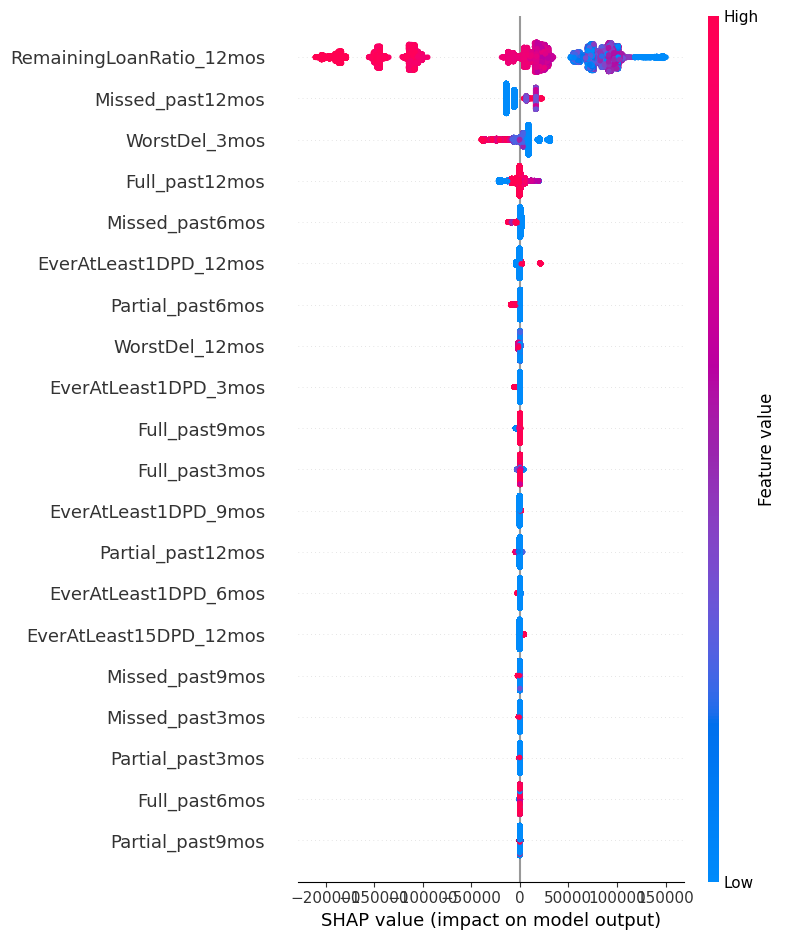

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

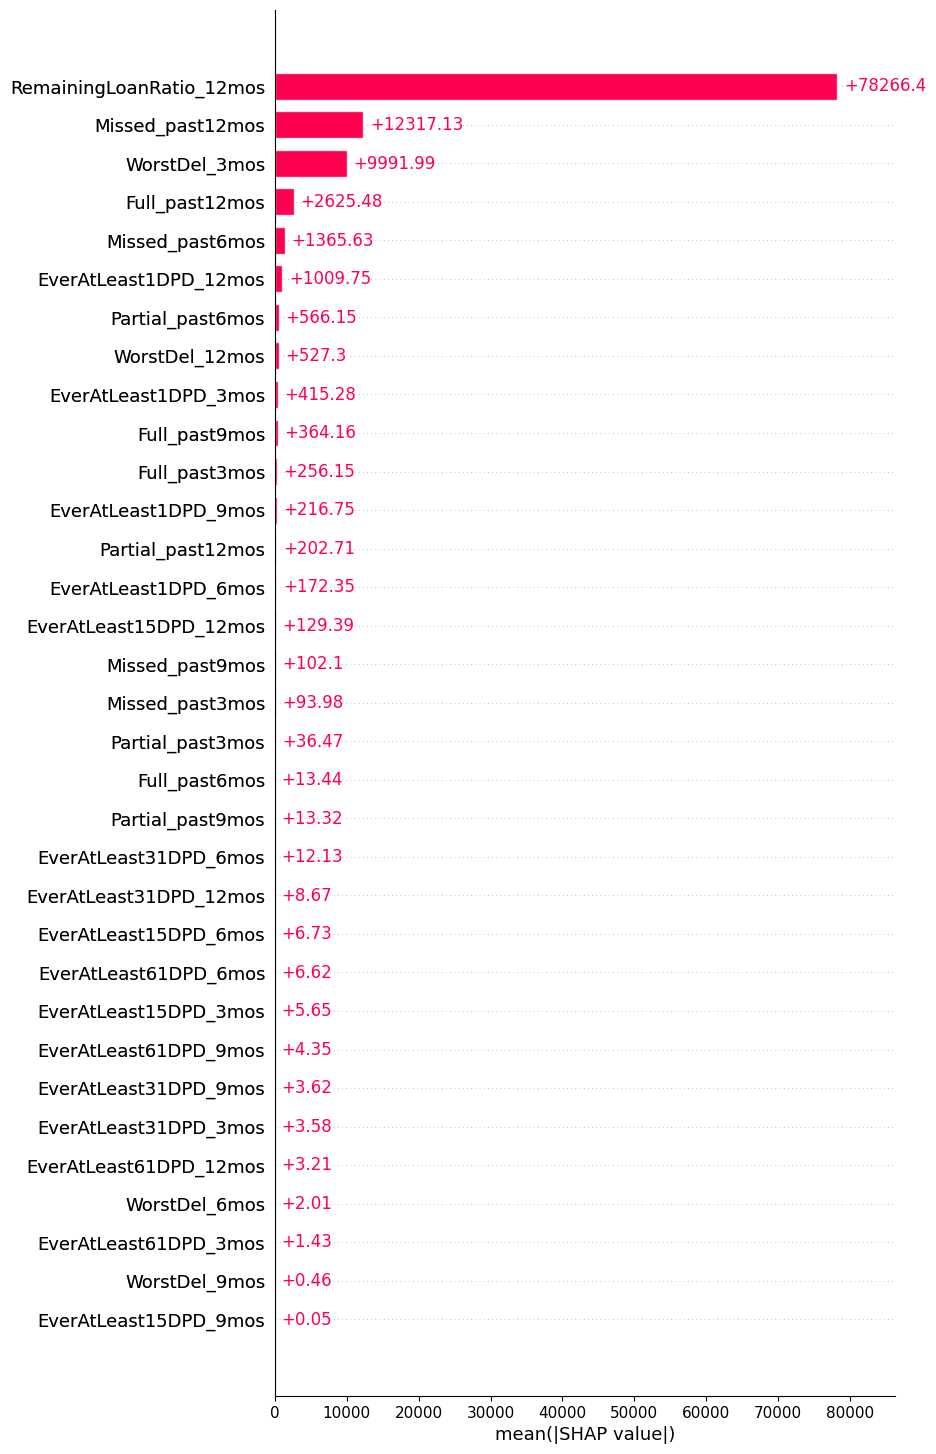

In [23]:
shap.plots.bar(shap_values, max_display=50)

In [24]:
# Step 1: Get mean absolute SHAP values per feature
shap_summary = np.abs(shap_values.values).mean(axis=0)

# Step 2: Create a DataFrame with feature names and their mean SHAP values
shap_df = pd.DataFrame({
    'Feature': shap_values.feature_names,
    'Mean |SHAP value|': shap_summary
})

# Step 3: Sort descending to match what shap.plots.bar shows
shap_df = shap_df.sort_values(by='Mean |SHAP value|', ascending=False)

# Step 4 (Optional): Show top N
top_n = 50
print(shap_df.head(top_n))

                     Feature  Mean |SHAP value|
20  RemainingLoanRatio_12mos       78266.399197
30          Missed_past12mos       12317.134246
16             WorstDel_3mos        9991.990821
32            Full_past12mos        2625.484253
24           Missed_past6mos        1365.632526
12     EverAtLeast1DPD_12mos        1009.753475
25          Partial_past6mos         566.151489
19            WorstDel_12mos         527.297595
0       EverAtLeast1DPD_3mos         415.281610
29             Full_past9mos         364.158165
23             Full_past3mos         256.147001
8       EverAtLeast1DPD_9mos         216.747981
31         Partial_past12mos         202.705335
4       EverAtLeast1DPD_6mos         172.345762
13    EverAtLeast15DPD_12mos         129.392772
27           Missed_past9mos         102.100629
21           Missed_past3mos          93.979357
22          Partial_past3mos          36.474044
26             Full_past6mos          13.443919
28          Partial_past9mos          13